Script from Chelsey to read classifier results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import pickle
import glob

### Plotting settings

In [28]:

palette = sns.color_palette('colorblind')
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 13
BIGGER_SIZE = 15
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Figs/'

### Read results for any classifier

In [3]:
path = r'F:/Nya-AZKABAN/Zooplankton_17012022/Classification'

In [4]:
def read_results (classifier,path):
    ' read the classifier results and predictions from the selected classifier'
    
    if classifier =='kNN_NewCopepods':
        main_path = f'{path}/2022-11-15_{classifier}_NewTracks/2022-11-15_kNN_AZKABAN_Repaired'
        pred_path = '_Predictions.pkl'
        cv_path = '_NestedCV.pkl'
        trackavg_path = '_NewTracks_TrackAvg_Predictions.pkl'
        tracked_path = '_NewTracks_SED-Tracked_Predictions.pkl'
        best_params = '_BestParams.pkl'

        model_path = f'{path}/AZKABAN_ZoopMix_data_newcopepod.feather'

    elif classifier =='kNN_SameCopepods':
        main_path = f'{path}/2022-11-30_{classifier}_NewTracks/2022-11-30_kNN_AZKABAN'
        pred_path = '_Predictions.pkl'
        cv_path = '_NestedCV.pkl'
        trackavg_path = '_TrackAverage_Predictions.pkl'
        tracked_path = '_Tracked_Predictions.pkl'
        best_params = '_BestParams.pkl'

        model_path = f'{path}/AZKABAN_ZoopMix_data_NewJelly.feather'

    else:
        main_path = f'{path}/2022-12-04_{classifier}_NewTracks/'
        pred_path = f'2022-07-04_{classifier}_AZKABAN_Predictions.pkl'
        cv_path = f'2022-07-04_{classifier}_AZKABAN_NestedCV.pkl'
        trackavg_path = f'2022-12-04_{classifier}_AZKABAN_TrackAveragePredictions.pkl'
        tracked_path = f'2022-12-04_{classifier}_AZKABAN_TrackedPredictions.pkl'
        best_params = f'2022-07-04_{classifier}_AZKABAN_BestParams.pkl'

        model_path = f'{path}/AZKABAN_ZoopMix_data_NewJelly.feather'

    # Load dataframes
    pred_df = pd.read_pickle(main_path+pred_path) # Echoview SED file with kNN-predicted labels
    pred_df.reset_index(drop=True, inplace=True)
    cv_df = pd.read_pickle(main_path + cv_path) # Nested CV results
    trackavg_df = pd.read_pickle(main_path + trackavg_path)
    tracked_df = pd.read_pickle(main_path + tracked_path)
    if classifier !='LightGBM':
        best_params = pd.read_pickle(main_path + best_params)
    model_df = pd.read_feather(model_path)  

    # Replace Jellyfish with Hydrozoans
    model_df = model_df.replace('Jellyfish','Hydrozoans',regex=True)
    pred_df = pred_df.replace('Jellyfish','Hydrozoans', regex=True)
    cv_df = cv_df.replace('Jellyfish','Hydrozoans', regex=True)
    trackavg_df = trackavg_df.replace('Jellyfish','Hydrozoans', regex=True)
    tracked_df = tracked_df.replace('Jellyfish','Hydrozoans', regex=True)
          
    # Restructure model_df to match ev_df
    n_species = len(model_df.spec.unique())
    n_models_per_species = 1000

    freqs = [float(i) for i in model_df.freq.unique()]
    n_model_f_bins = len(freqs) # No. of freq bins

    X_list = []
    y_list = []
    start_lim = 0
    stop_lim = n_model_f_bins

    for i in range(n_species * n_models_per_species):
        TS_array = model_df.TS[start_lim:stop_lim].values
        species_label = model_df.spec[start_lim:stop_lim].values[0]

        X_list.append(TS_array)
        y_list.append(species_label)

        start_lim += n_model_f_bins
        stop_lim += n_model_f_bins

    model_df = pd.DataFrame(X_list, columns=freqs)
    model_df['Species'] = y_list
    
    return {'name':classifier, 'model_df':model_df, 'pred_df':pred_df, 'cv_df':cv_df, 'trackavg_df':trackavg_df, 'tracked_df':tracked_df, 'best_params':best_params}

# Read results

In [5]:
kNN = read_results('kNN_SameCopepods',path)
kNN_antarctica = read_results('kNN_NewCopepods',path)
SVM = read_results('SVM',path)
LightGBM = read_results('LightGBM',path)


# Model Parameters

In [6]:
kNN['best_params']

{'learner': KNeighborsClassifier(algorithm='kd_tree', leaf_size=28, n_jobs=4, n_neighbors=2,
                      p=4.6990248269922095, weights='distance'),
 'preprocs': (),
 'ex_preprocs': ()}

In [7]:
kNN_antarctica['best_params']

{'learner': KNeighborsClassifier(algorithm='ball_tree', leaf_size=34, n_jobs=-1,
                      n_neighbors=1, p=3.496051065843911, weights='distance'),
 'preprocs': (),
 'ex_preprocs': ()}

In [8]:
SVM['best_params']

{'learner': SVC(C=3.0441999698185898, coef0=0.8873087063060306,
     decision_function_shape='ovo', degree=2, gamma='auto', random_state=2,
     tol=0.0002500517618989924),
 'preprocs': (),
 'ex_preprocs': ()}

In [9]:
LightGBM['best_params']

'2022-07-04_LightGBM_AZKABAN_BestParams.pkl'

# Nested Cross-Validation

In [10]:
def print_F1_mean(classifier):
    cv_df = classifier['cv_df']
    
    print('Mean class-weighted F1 score for : '
          + str(round(cv_df.Outer_score.mean(), 2))
          + ' ± '
          + str(round(cv_df.Outer_score.std(), 2)))

    mean_class_scores = np.mean(np.vstack(cv_df.Outer_unweighted_scores.values), axis=0)
    std_class_scores = np.std(np.vstack(cv_df.Outer_unweighted_scores.values), axis=0)

    for i, species in enumerate(cv_df.Outer_unweighted_score_labels.values[0]):
        print('Mean F1 score for ' + species + ': '
             + str(round(mean_class_scores[i], 2))
             + ' ± '
             + str(round(std_class_scores[i], 2)))
        

In [11]:
print_F1_mean(kNN)

Mean class-weighted F1 score for : 0.67 ± 0.03
Mean F1 score for Chaetognaths: 0.53 ± 0.06
Mean F1 score for Copepods: 0.88 ± 0.03
Mean F1 score for Euphausiids: 0.69 ± 0.03
Mean F1 score for Jellyfish: 0.59 ± 0.02


In [12]:
print_F1_mean(kNN_antarctica)

Mean class-weighted F1 score for : 0.65 ± 0.02
Mean F1 score for Chaetognaths: 0.5 ± 0.04
Mean F1 score for Copepods: 0.82 ± 0.01
Mean F1 score for Euphausiids: 0.7 ± 0.02
Mean F1 score for Jellyfish: 0.58 ± 0.05


In [13]:
print_F1_mean(SVM)

Mean class-weighted F1 score for : 0.68 ± 0.02
Mean F1 score for Chaetognaths: 0.48 ± 0.04
Mean F1 score for Copepods: 0.92 ± 0.02
Mean F1 score for Euphausiids: 0.7 ± 0.04
Mean F1 score for Jellyfish: 0.63 ± 0.02


In [14]:
print_F1_mean(LightGBM)

Mean class-weighted F1 score for : 0.64 ± 0.01
Mean F1 score for Chaetognaths: 0.47 ± 0.03
Mean F1 score for Copepods: 0.87 ± 0.02
Mean F1 score for Euphausiids: 0.68 ± 0.03
Mean F1 score for Jellyfish: 0.53 ± 0.03


Text(0.5, 1.0, 'LightGBM')

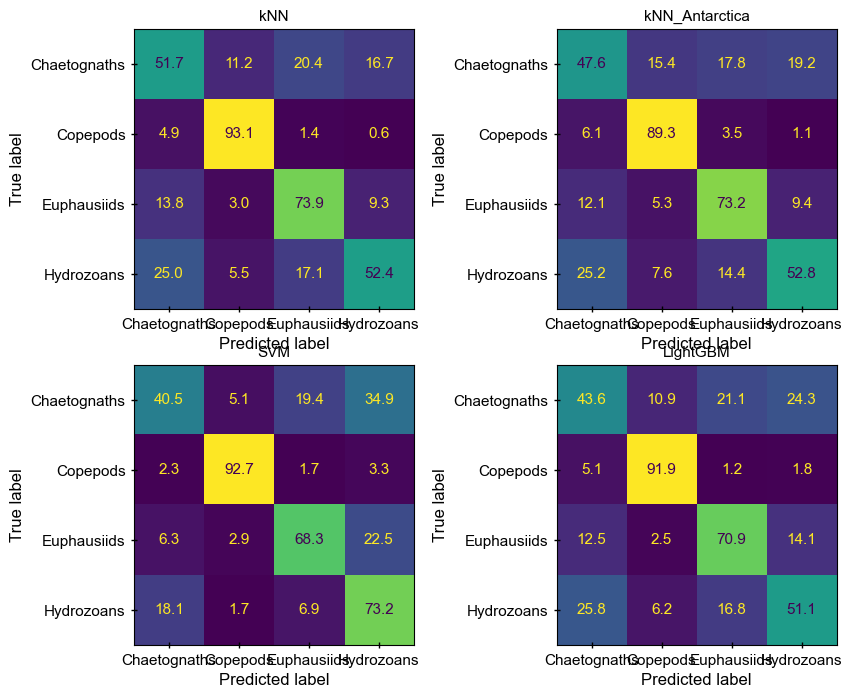

In [15]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
axes = ax.flatten()
labels = ['Chaetognaths', 'Copepods','Euphausiids', 'Hydrozoans']

cmp_kNN = ConfusionMatrixDisplay(kNN['cv_df'].Outer_confusion_matrix.mean(),
                             display_labels=labels)
cmp_kNN.plot(ax=axes[0], colorbar=False, values_format='.1f')
axes[0].set_title('kNN')

cmp_kNN_a = ConfusionMatrixDisplay(kNN_antarctica['cv_df'].Outer_confusion_matrix.mean(),
                             display_labels=labels)
cmp_kNN_a.plot(ax=axes[1], colorbar=False, values_format='.1f')
axes[1].set_title('kNN_Antarctica')

cmp_SVM = ConfusionMatrixDisplay(SVM['cv_df'].Outer_confusion_matrix.mean(),
                             display_labels=labels)
cmp_SVM.plot(ax=axes[2], colorbar=False, values_format='.1f')
axes[2].set_title('SVM')

cmp_LGBM = ConfusionMatrixDisplay(LightGBM['cv_df'].Outer_confusion_matrix.mean(),
                             display_labels=labels)
cmp_LGBM.plot(ax=axes[3], colorbar=False, values_format='.1f')
axes[3].set_title('LightGBM')

In [16]:
# Calculate STD

In [17]:
def calculate_confusion_matrix_sd(classifier):
    sd = np.std(np.vstack(classifier['cv_df'].Outer_confusion_matrix[:]).reshape(500,4,4),axis=0)
    return sd

In [18]:
calculate_confusion_matrix_sd(kNN_antarctica)

array([[4.71593045, 4.24735212, 5.28772163, 3.37045991],
       [2.58650343, 3.60693776, 1.36014705, 0.94339811],
       [3.08058436, 2.23830293, 3.81575681, 2.72763634],
       [5.19230199, 2.45764115, 2.45764115, 6.25779514]])

Similar trends across classifiers. SVM is more successful at classifying Hydrozoans than the other methods and worse at classifying euphausiids.
The kNN trained with copepods parametrized with Antarctic properties is slightly more likely to mislabel chaetognaths and copepods.

# Single targets

In [19]:
def plot_pred(classifier, ax):
    pred_df = classifier['pred_df']
    ax.bar(pred_df.Prediction.value_counts().index,
            pred_df.Prediction.value_counts().values,
            color='k')
    ax.set_xlabel('Species')
    ax.set_title(classifier['name'])
    ax.set_ylabel('Count')

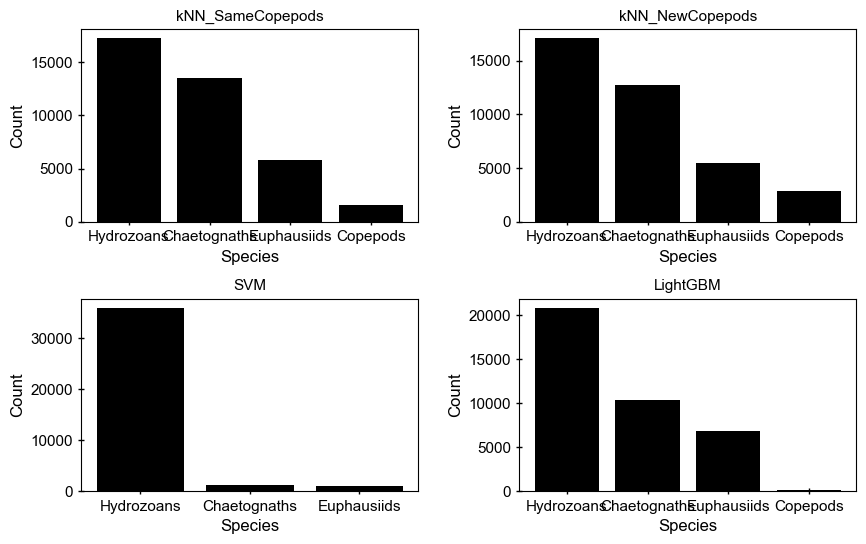

In [20]:
fig,ax = plt.subplots(2,2,figsize=(10,6))
fig.subplots_adjust(hspace=.4, wspace=0.3)
axes = ax.flatten()
plot_pred(kNN, ax=axes[0])
plot_pred(kNN_antarctica, ax=axes[1])
plot_pred(SVM, ax=axes[2])
plot_pred(LightGBM, ax=axes[3])

In [21]:
# Calculate difference between predicted SED kNN vs kNN_antarctica
print(kNN['pred_df'].Prediction.value_counts().Copepods)
print(kNN_antarctica['pred_df'].Prediction.value_counts().Copepods/np.sum(kNN_antarctica['pred_df'].Prediction.value_counts()))

1597
0.07535609551738584


In [22]:
def compare_TS(classifier):
    model_df = classifier['model_df']
    pred_df = classifier['pred_df']
    
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4,
                                               figsize=(8,2),
                                               sharex=True,
                                               sharey=True)
    top_axes = [ax1, ax2, ax3, ax4]
    species = model_df.Species.unique()
    
    #model freqs
    freqs_all = model_df.columns[:-1].to_numpy()
    ind_s = np.where(freqs_all == 185.0)[0][0]
    ind_e = np.where(freqs_all == 255.0)[0][0]
    freqs_model = freqs_all[ind_s:ind_e]
    freqs_model = freqs_model.astype('float64')
    
    
    freqs_all_pred = pred_df.columns[3:-2].to_numpy()
    ind_s = np.where(freqs_all_pred == '185.000')[0][0]
    ind_e = np.where(freqs_all_pred == '255.000')[0][0]
    freqs_pred = freqs_all_pred[ind_s:ind_e+1]
    freqs_pred = freqs_pred.astype('float64')

    for i, ax in enumerate(top_axes):
        spectra_model = model_df[model_df.Species == species[i]].iloc[:,ind_s:ind_e]
        spectra_model = spectra_model.astype('float64')
        
        ax.plot(freqs_model,
                spectra_model.median(),
                label='Modelled',
                color=palette[0])
        
        ax.fill_between(freqs_model,
                        spectra_model.quantile(q=0.25),
                        spectra_model.quantile(q=0.75),
                        alpha=0.4,
                        color=palette[0])

        ax.set_title(species[i], fontsize=BIGGER_SIZE, fontweight='bold')

        if i == len(top_axes)-1:
            ax.legend()

    for i, ax in enumerate(top_axes):
        spectra_pred = pred_df[pred_df.Prediction == species[i]].iloc[:,3+ind_s:ind_e+4]
        spectra_pred = spectra_pred.astype('float64')
        
        ax.plot(freqs_pred,
                spectra_pred.median(),
                label='Measured',
                color=palette[1])
        ax.fill_between(freqs_pred,
                        spectra_pred.quantile(q=0.25),
                        spectra_pred.quantile(q=0.75),
                        alpha=0.4,
                        color=palette[1])

        ax.set_xlabel('Frequency (kHz)')

        if i == len(top_axes)-1:
            ax.legend()

    ax1.set_ylabel('TS (dB re 1 $\mathregular{m^2}$)')
    plt.tight_layout()
    plt.show()

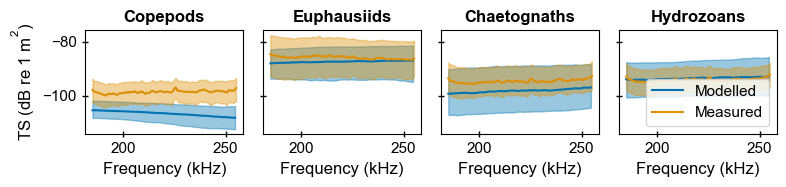

In [23]:
compare_TS(kNN_antarctica)

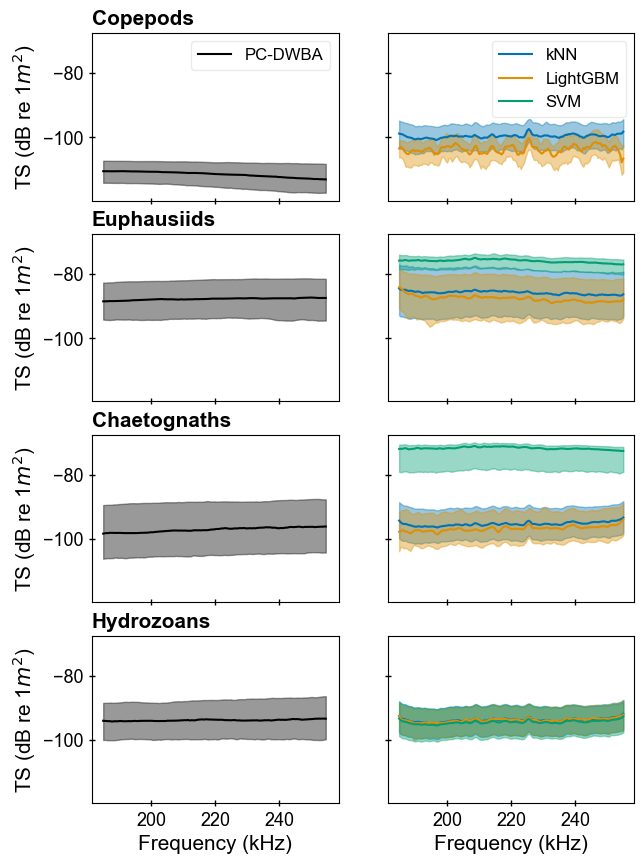

In [35]:
model_df = kNN['model_df']

fig, ax = plt.subplots(4, 2, figsize=(7,10), sharex=True, sharey=True)
axes = ax.flatten()
left_axes = axes[0:-1:2]
right_axes = axes[1::2]
species = model_df.Species.unique()


#model freqs
freqs_all = model_df.columns[:-1].to_numpy()
ind_s = np.where(freqs_all == 185.0)[0][0]
ind_e = np.where(freqs_all == 255.0)[0][0]
freqs_model = freqs_all[ind_s:ind_e]
freqs_model = freqs_model.astype('float64')



for i, ax in enumerate(left_axes):
    spectra_model = model_df[model_df.Species == species[i]].iloc[:,ind_s:ind_e]
    spectra_model = spectra_model.astype('float64')

    ax.plot(freqs_model,
            spectra_model.median(),
            label='Modelled',
            color='k')

    ax.fill_between(freqs_model,
                    spectra_model.quantile(q=0.25),
                    spectra_model.quantile(q=0.75),
                    alpha=0.4,
                    color='k')

    ax.set_title(species[i], fontsize=BIGGER_SIZE, fontweight='bold', loc='left')
    ax.set_ylabel('TS (dB re 1${m^2}$)')

    if i == len(left_axes):
        ax.legend()
k=-1
for i_class in [kNN, LightGBM, SVM]:
    pred_df = i_class['pred_df']
    freqs_all_pred = pred_df.columns[3:-2].to_numpy()
    ind_s = np.where(freqs_all_pred == '185.000')[0][0]
    ind_e = np.where(freqs_all_pred == '255.000')[0][0]
    freqs_pred = freqs_all_pred[ind_s:ind_e+1]
    freqs_pred = freqs_pred.astype('float64')
    
    name = ['kNN', 'LightGBM', 'SVM']
    color = [0,1,2]
    k+=1
    
    
    for i, ax in enumerate(right_axes):
        spectra_pred = pred_df[pred_df.Prediction == species[i]].iloc[:,3+ind_s:ind_e+4]
        spectra_pred = spectra_pred.astype('float64')

        ax.plot(freqs_pred,
                spectra_pred.median(),
                label=name[k],
                color=palette[color[k]])
        ax.fill_between(freqs_pred,
                        spectra_pred.quantile(q=0.25),
                        spectra_pred.quantile(q=0.75),
                        alpha=0.4,
                        color=palette[color[k]])
        
axes[0].legend(['PC-DWBA'],fontsize=12, framealpha=0.4, loc='upper right')
axes[1].legend(fontsize=12, framealpha=0.4, loc='upper right')

axes[6].set_xlabel('Frequency (kHz)')
axes[7].set_xlabel('Frequency (kHz)')

for i_ax in range(len(axes)):
    axes[i_ax].set_rasterized(True)


fig.savefig(savefigs_path+'Figure_spectra.jpg', format='jpg', dpi = 600, facecolor='w', bbox_inches='tight')

# Tracked single targets

In [25]:
def plot_tracked(classifier, ax):
    tracked_df = classifier['tracked_df']
    ax.bar(tracked_df.Prediction.value_counts().index,
            tracked_df.Prediction.value_counts().values,
            color='k')
    ax.set_title(classifier['name'])
    ax.set_xlabel('Species')
    ax.set_ylabel('Count')

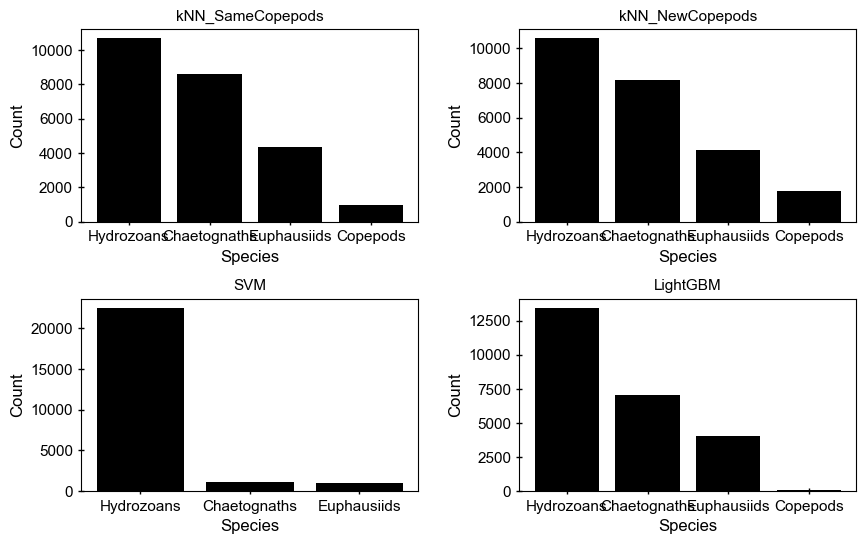

In [26]:
fig, ax = plt.subplots(2,2, figsize=(10,6))
fig.subplots_adjust(hspace=.4, wspace=0.3)
axes = ax.flatten()

plot_tracked(kNN, axes[0])
plot_tracked(kNN_antarctica, axes[1])
plot_tracked(SVM, axes[2])
plot_tracked(LightGBM, axes[3])

NameError: name 'freqs' is not defined

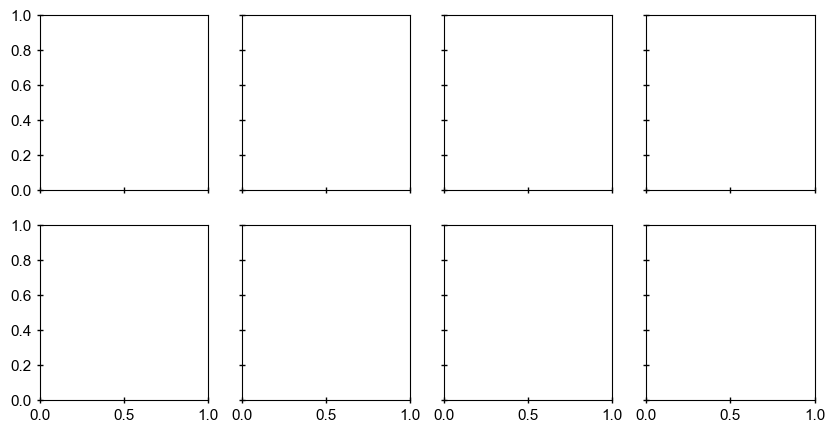

In [27]:
fig, ((ax1, ax2, ax3, ax4),
      (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4,
                                           figsize=(10,5),
                                           sharex=True,
                                           sharey=True)
top_axes = [ax1, ax2, ax3, ax4]
bottom_axes = [ax5, ax6, ax7, ax8]
species = model_df.Species.unique()

for i, ax in enumerate(top_axes):
    ax.plot(freqs,
            model_df[model_df.Species == species[i]].iloc[:,:].median(),
            label='Modelled',
            color=palette[0])
    ax.fill_between(freqs,
                    model_df[model_df.Species == species[i]].iloc[:,:].quantile(q=0.25),
                    model_df[model_df.Species == species[i]].iloc[:,:].quantile(q=0.75),
                    alpha=0.4,
                    color=palette[0])
    
    ax.set_title(species[i], fontsize=BIGGER_SIZE, fontweight='bold')
    
    if i == len(top_axes)-1:
        ax.legend()

for i, ax in enumerate(bottom_axes):
    ax.plot(freqs,
            tracked_df[tracked_df.Prediction == species[i]].iloc[:,8:-1].median(),
            label='Measured',
            color=palette[1])
    ax.fill_between(freqs,
                    tracked_df[tracked_df.Prediction == species[i]].iloc[:,8:-1].quantile(q=0.25),
                    tracked_df[tracked_df.Prediction == species[i]].iloc[:,8:-1].quantile(q=0.75),
                    alpha=0.4,
                    color=palette[1])
    
    ax.set_xlabel('Frequency (kHz)')
    
    if i == len(bottom_axes)-1:
        ax.legend()

ax1.set_ylabel('TS (dB re 1 $\mathregular{m^2}$)')
ax5.set_ylabel('TS (dB re 1 $\mathregular{m^2}$)')
plt.tight_layout()
plt.show()

# Track averages

In [ ]:
plt.figure(figsize=(5,4))
plt.bar(trackavg_df.Prediction.value_counts().index,
        trackavg_df.Prediction.value_counts().values,
        color='k')
plt.tight_layout()
plt.xlabel('Species')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
fig, ((ax1, ax2, ax3, ax4),
      (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4,
                                           figsize=(10,5),
                                           sharex=True,
                                           sharey=True)
top_axes = [ax1, ax2, ax3, ax4]
bottom_axes = [ax5, ax6, ax7, ax8]
species = model_df.Species.unique()

for i, ax in enumerate(top_axes):
    ax.plot(freqs,
            model_df[model_df.Species == species[i]].iloc[:,:].median(),
            label='Modelled',
            color=palette[0])
    ax.fill_between(freqs,
                    model_df[model_df.Species == species[i]].iloc[:,:].quantile(q=0.25),
                    model_df[model_df.Species == species[i]].iloc[:,:].quantile(q=0.75),
                    alpha=0.4,
                    color=palette[0])
    
    ax.set_title(species[i], fontsize=BIGGER_SIZE, fontweight='bold')
    
    if i == len(top_axes)-1:
        ax.legend()

for i, ax in enumerate(bottom_axes):
    ax.plot(freqs,
            trackavg_df[trackavg_df.Prediction == species[i]].iloc[:,14:-1].median(),
            label='Measured',
            color=palette[1])
    ax.fill_between(freqs,
                    trackavg_df[trackavg_df.Prediction == species[i]].iloc[:,14:-1].quantile(q=0.25),
                    trackavg_df[trackavg_df.Prediction == species[i]].iloc[:,14:-1].quantile(q=0.75),
                    alpha=0.4,
                    color=palette[1])
    
    ax.set_xlabel('Frequency (kHz)')
    
    if i == len(bottom_axes)-1:
        ax.legend()

ax1.set_ylabel('TS (dB re 1 $\mathregular{m^2}$)')
ax5.set_ylabel('TS (dB re 1 $\mathregular{m^2}$)')
plt.tight_layout()
plt.show()